In [636]:
import os
import numpy as np
import pandas as pd
import swifter
import warnings
from loguru import logger

from exonamd.catalog import download_nasa_confirmed_planets
from exonamd.utils import ROOT
from exonamd.utils import fetch_aliases
from exonamd.utils import update_host
from exonamd.utils import update_planet
from exonamd.utils import check_name
from exonamd.solve import solve_values
from exonamd.interp import interp_eccentricity
from exonamd.interp import interp_mass
from exonamd.interp import interp_inclination
from exonamd.interp import interp_sma
from exonamd.solve import solve_relincl
from exonamd.interp import interp_trueobliq
from exonamd.utils import groupby_apply_merge
from exonamd.solve import solve_namd
from exonamd.solve import solve_namd_mc
from exonamd.plot import plot_host_namd
from exonamd.plot import pop_plot


warnings.filterwarnings("ignore")
pd.options.display.max_columns = 20
pd.options.display.max_rows = 30
pd.options.mode.copy_on_write = True
swifter.set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler="processes",
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=False,
    force_parallel=False,
)

In [637]:
# fetch_aliases(["Kepler-90"])

In [638]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [639]:
df = pd.read_csv(
    os.path.join('../exonamd', "data", "custom_db_20241227_plus_famous.csv"),
)

### Task 3: computing missing values (if any) from simple relations


In [640]:
logger.info("Computing missing values from simple relations")
df[
    [
        "pl_orbsmax",
        "pl_ratdor",
        "st_rad",
        "pl_rade",
        "pl_ratror",
        "pl_orbper",
        "st_mass",
    ]
] = df.swifter.apply(solve_values, axis=1)
logger.info("Missing values computed")

2024-12-27 17:04:59.571 | INFO     | __main__:<module>:1 - Computing missing values from simple relations


Pandas Apply:   0%|          | 0/72 [00:00<?, ?it/s]

2024-12-27 17:04:59.667 | INFO     | __main__:<module>:13 - Missing values computed


### Task 4: storing the curated database


Drop columns that are no longer needed


In [641]:
logger.debug("Dropping columns that are no longer needed")
df.drop(
    columns=[
        "pl_ratdor",
        "st_rad",
        "pl_ratror",
        "pl_orbper",
        "st_mass",
    ],
    inplace=True,
)
logger.debug("Columns dropped")

2024-12-27 17:04:59.738 | DEBUG    | __main__:<module>:1 - Dropping columns that are no longer needed
2024-12-27 17:04:59.741 | DEBUG    | __main__:<module>:12 - Columns dropped


In [642]:
logger.info("Storing the curated database")

out_path = os.path.join(ROOT, "data", "exo_custom_db_20241227_plus_famous.csv")
df.to_csv(out_path, index=False)
logger.info(f"Database stored at {out_path}")

2024-12-27 17:04:59.814 | INFO     | __main__:<module>:1 - Storing the curated database
2024-12-27 17:04:59.819 | INFO     | __main__:<module>:5 - Database stored at /export/NAS/ariel/users/andrea.bocchieri/.local/lib/python3.10/site-packages/exonamd/data/exo_custom_db_20241227_plus_famous.csv


### Task 5: input missing values (if any) by interpolation


Use nanmedian to thin down the data


In [643]:
logger.info("Thinning down the data with nanmedian")
cols = df.columns.difference(["hostname", "pl_name", "default_flag", "rowupdate"])
medians = df.groupby("pl_name")[cols].transform(np.nanmedian)
df.loc[df["default_flag"] == 1, cols] = medians.loc[df["default_flag"] == 1]
df = df[df["default_flag"] == 1].drop(columns="default_flag")
logger.info("Data thinned down")

2024-12-27 17:04:59.893 | INFO     | __main__:<module>:1 - Thinning down the data with nanmedian


2024-12-27 17:04:59.908 | INFO     | __main__:<module>:6 - Data thinned down


Check presence of duplicates (if any)


In [644]:
logger.info("Checking for duplicates")
dp = df[df.duplicated(subset=["hostname", "pl_name"], keep=False)].sort_values(
    by=["hostname", "pl_name"]
)

if len(dp) > 0:
    logger.error(f"Duplicated rows for {dp['hostname'].unique()}")
    raise ValueError(f"Duplicated rows for {dp['hostname'].unique()}")
logger.info("No duplicates found")

2024-12-27 17:05:00.010 | INFO     | __main__:<module>:1 - Checking for duplicates


2024-12-27 17:05:00.014 | INFO     | __main__:<module>:9 - No duplicates found


Instantiate flags


In [645]:
logger.info("Instantiating the flags")
df["flag"] = "0"
logger.info("Flags instantiated")

2024-12-27 17:05:00.069 | INFO     | __main__:<module>:1 - Instantiating the flags
2024-12-27 17:05:00.071 | INFO     | __main__:<module>:3 - Flags instantiated


Solve missing eccentricity values


In [646]:
logger.info("Interpolating missing eccentricity values")
df[
    [
        "pl_orbeccen",
        "pl_orbeccenerr1",
        "pl_orbeccenerr2",
        "flag",
    ]
] = df.swifter.apply(interp_eccentricity, axis=1)
logger.info("Values interpolated")

2024-12-27 17:05:00.184 | INFO     | __main__:<module>:1 - Interpolating missing eccentricity values


Pandas Apply:   0%|          | 0/72 [00:00<?, ?it/s]

2024-12-27 17:05:00.240 | INFO     | __main__:<module>:10 - Values interpolated


Solve missing planetary mass values


In [647]:
logger.info("Interpolating missing planetary mass values")
df[
    [
        "pl_bmasse",
        "pl_bmasseerr1",
        "pl_bmasseerr2",
        "flag",
    ]
] = df.swifter.apply(interp_mass, axis=1)
logger.info("Values interpolated")

2024-12-27 17:05:00.304 | INFO     | __main__:<module>:1 - Interpolating missing planetary mass values


Pandas Apply:   0%|          | 0/72 [00:00<?, ?it/s]

2024-12-27 17:05:02.228 | INFO     | __main__:<module>:10 - Values interpolated


Drop columns that are no longer needed


In [648]:
logger.debug("Dropping columns that are no longer needed")
df.drop(columns=["pl_rade", "pl_radeerr1", "pl_radeerr2"], inplace=True)
logger.debug("Columns dropped")

2024-12-27 17:05:02.307 | DEBUG    | __main__:<module>:1 - Dropping columns that are no longer needed
2024-12-27 17:05:02.311 | DEBUG    | __main__:<module>:3 - Columns dropped


Remove systems where at least one planet has no mass or semi-major axis (if any)


In [649]:
logger.info("Removing systems where at least one planet has no mass or semi-major axis")
mask = (
    df.groupby("hostname")[["pl_bmasse", "pl_orbsmax"]]
    .transform(lambda x: x.isnull().any())
    .any(axis=1)
)
rm_systems = df[mask]["hostname"].unique()
logger.info(f"Removing {len(rm_systems)} systems: {rm_systems}")
df = df[~mask]
logger.info("Systems removed")

2024-12-27 17:05:02.396 | INFO     | __main__:<module>:1 - Removing systems where at least one planet has no mass or semi-major axis
2024-12-27 17:05:02.412 | INFO     | __main__:<module>:8 - Removing 1 systems: ['KOI-351']
2024-12-27 17:05:02.414 | INFO     | __main__:<module>:10 - Systems removed


Solve missing values in inclinations


In [650]:
logger.info("Interpolating missing values in inclinations")
df[
    [
        "pl_orbincl",
        "pl_orbinclerr1",
        "pl_orbinclerr2",
        "flag",
    ]
] = df.swifter.apply(interp_inclination, args=(df,), axis=1)
logger.info("Values interpolated")

2024-12-27 17:05:02.492 | INFO     | __main__:<module>:1 - Interpolating missing values in inclinations


Pandas Apply:   0%|          | 0/64 [00:00<?, ?it/s]

2024-12-27 17:05:02.630 | INFO     | __main__:<module>:10 - Values interpolated


Interpolate missing values in semi-major axis uncertainties


In [651]:
logger.info("Interpolating missing values in semi-major axis uncertainties")
df[
    [
        "pl_orbsmaxerr1",
        "pl_orbsmaxerr2",
        "flag",
    ]
] = df.swifter.apply(interp_sma, axis=1)
logger.info("Values interpolated")

2024-12-27 17:05:02.726 | INFO     | __main__:<module>:1 - Interpolating missing values in semi-major axis uncertainties


Pandas Apply:   0%|          | 0/64 [00:00<?, ?it/s]

2024-12-27 17:05:02.780 | INFO     | __main__:<module>:9 - Values interpolated


### Task 6: compute the parameters for the NAMD calculation


Compute the relative inclination


In [652]:
logger.info("Computing the relative inclinations")
df[
    [
        "pl_relincl",
        "pl_relinclerr1",
        "pl_relinclerr2",
    ]
] = df.swifter.apply(solve_relincl, args=(df,), axis=1)
logger.info("Values computed")

2024-12-27 17:05:02.840 | INFO     | __main__:<module>:1 - Computing the relative inclinations


Pandas Apply:   0%|          | 0/64 [00:00<?, ?it/s]

2024-12-27 17:05:02.965 | INFO     | __main__:<module>:9 - Values computed


Interpolate missing values in true obliquity


In [653]:
logger.info("Interpolating missing values in true obliquity")
df[
    [
        "pl_trueobliq",
        "pl_trueobliqerr1",
        "pl_trueobliqerr2",
        "flag",
    ]
] = df.swifter.apply(interp_trueobliq, args=(df,), axis=1)
logger.info("Values interpolated")

2024-12-27 17:05:03.018 | INFO     | __main__:<module>:1 - Interpolating missing values in true obliquity


Pandas Apply:   0%|          | 0/64 [00:00<?, ?it/s]

2024-12-27 17:05:03.186 | INFO     | __main__:<module>:10 - Values interpolated


### Task 7: storing the curated+interpolated database


In [654]:
logger.info("Storing the curated+interpolated database")
out_path = os.path.join(ROOT, "data", "exo_interp_custom_db_20241227_plus_famous.csv")
df.to_csv(out_path, index=False)
logger.info(f"Database stored at {out_path}")

2024-12-27 17:05:03.287 | INFO     | __main__:<module>:1 - Storing the curated+interpolated database
2024-12-27 17:05:03.292 | INFO     | __main__:<module>:4 - Database stored at /export/NAS/ariel/users/andrea.bocchieri/.local/lib/python3.10/site-packages/exonamd/data/exo_interp_custom_db_20241227_plus_famous.csv


In [655]:
df = pd.read_csv(os.path.join(ROOT, "data", "exo_interp_custom_db_20241227_plus_famous.csv"))

### Task 8: computing the NAMD


Drop columns that are no longer needed

In [656]:
logger.debug("Dropping columns that are no longer needed")
df.drop(columns=["pl_orbincl", "pl_orbinclerr1", "pl_orbinclerr2"], inplace=True)
logger.debug("Columns dropped")

2024-12-27 17:05:03.538 | DEBUG    | __main__:<module>:1 - Dropping columns that are no longer needed


2024-12-27 17:05:03.540 | DEBUG    | __main__:<module>:3 - Columns dropped


Solve the relative and absolute namd


In [657]:
logger.info("Computing the relative NAMD")
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd,
    kind="rel",
    allow_overwrite=True,
)
logger.info("Relative NAMD computed")

2024-12-27 17:05:03.606 | INFO     | __main__:<module>:1 - Computing the relative NAMD


2024-12-27 17:05:03.666 | INFO     | __main__:<module>:9 - Relative NAMD computed


In [658]:
logger.info("Computing the absolute NAMD")
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd,
    kind="abs",
    allow_overwrite=True,
)
logger.info("Absolute NAMD computed")

2024-12-27 17:05:03.740 | INFO     | __main__:<module>:1 - Computing the absolute NAMD


2024-12-27 17:05:03.800 | INFO     | __main__:<module>:9 - Absolute NAMD computed


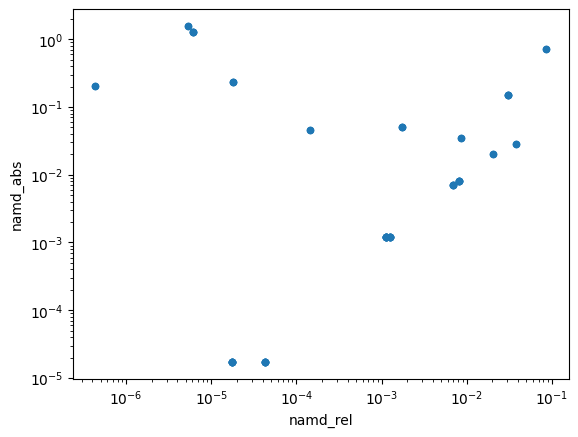

In [659]:
_ = (
    df.groupby("hostname")[["namd_rel", "namd_abs"]]
    .transform("mean")
    .plot(kind="scatter", x="namd_rel", y="namd_abs", loglog=True)
)

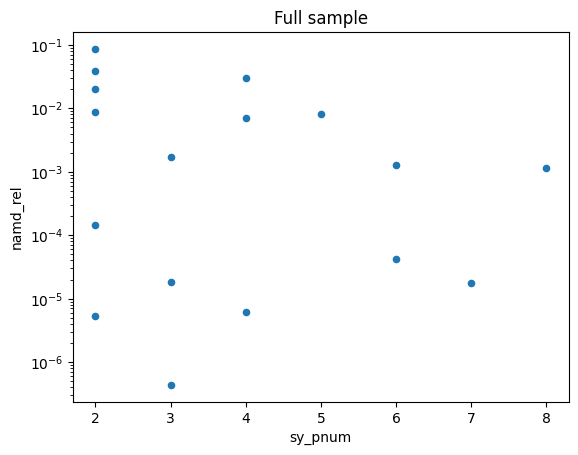

In [660]:
_ = (
    df.groupby("hostname")[["sy_pnum", "namd_rel"]]
    .mean()
    .reset_index()
    .plot(kind="scatter", x="sy_pnum", y="namd_rel", logy=True, title="Full sample")
)

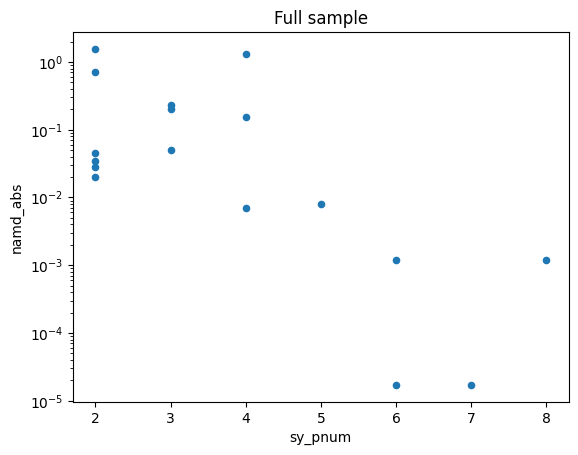

In [661]:
_ = (
    df.groupby("hostname")[["sy_pnum", "namd_abs"]]
    .mean()
    .reset_index()
    .plot(kind="scatter", x="sy_pnum", y="namd_abs", logy=True, title="Full sample")
)

### Task 9: computing the NAMD and associated confidence intervals


In [662]:
Npt = 200000
threshold = 1000

In [663]:
logger.info("Computing the Monte Carlo relative NAMD")
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd_mc,
    kind="rel",
    Npt=Npt,
    threshold=threshold,
    allow_overwrite=True,
)
logger.info("Relative NAMD computed")

2024-12-27 17:05:05.447 | INFO     | __main__:<module>:1 - Computing the Monte Carlo relative NAMD
2024-12-27 17:05:08.090 | INFO     | __main__:<module>:11 - Relative NAMD computed


In [664]:
logger.info("Computing the Monte Carlo absolute NAMD")
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd_mc,
    kind="abs",
    Npt=Npt,
    threshold=threshold,
    allow_overwrite=True,
)
logger.info("Absolute NAMD computed")

2024-12-27 17:05:08.156 | INFO     | __main__:<module>:1 - Computing the Monte Carlo absolute NAMD
2024-12-27 17:05:10.528 | INFO     | __main__:<module>:11 - Absolute NAMD computed


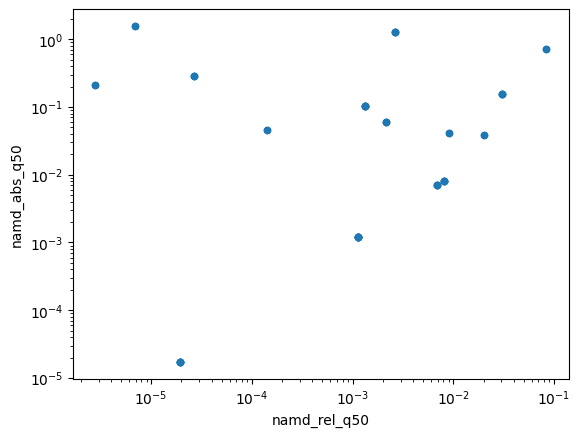

In [665]:
_ = (
    df.groupby("hostname")[["namd_rel_q50", "namd_abs_q50"]]
    .transform("mean")
    .plot(kind="scatter", x="namd_rel_q50", y="namd_abs_q50", loglog=True)
)

In [666]:
logger.info("Storing the NAMD database")
out_path = os.path.join(ROOT, "data", "exo_namd_custom_db_20241227_plus_famous.csv")
df.to_csv(out_path, index=False)
logger.info(f"Database stored at {out_path}")

2024-12-27 17:05:11.223 | INFO     | __main__:<module>:1 - Storing the NAMD database
2024-12-27 17:05:11.229 | INFO     | __main__:<module>:4 - Database stored at /export/NAS/ariel/users/andrea.bocchieri/.local/lib/python3.10/site-packages/exonamd/data/exo_namd_custom_db_20241227_plus_famous.csv


In [667]:
df = pd.read_csv(os.path.join(ROOT, "data", "exo_namd_custom_db_20241227_plus_famous.csv"))

### Some plots


2024-12-27 17:05:11.402 | INFO     | __main__:<module>:1 - Plotting the NAMD vs. multiplicity


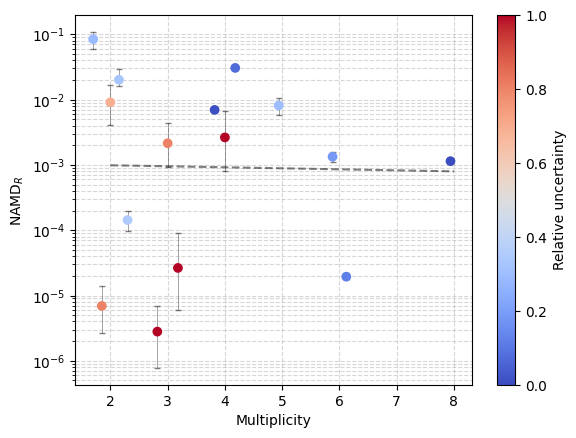

2024-12-27 17:05:11.793 | INFO     | __main__:<module>:12 - Plot done


In [668]:
logger.info("Plotting the NAMD vs. multiplicity")
pop_plot(
    df=df.groupby("hostname").apply(
        lambda g: g.select_dtypes(exclude=["object"]).mean(),
    ),
    kind="rel",
    # title="Core planets",
    which="namd",
    yscale="log",
    xoffs=True,
)
logger.info("Plot done")

2024-12-27 17:05:11.914 | INFO     | __main__:<module>:1 - Plotting the NAMD vs. multiplicity


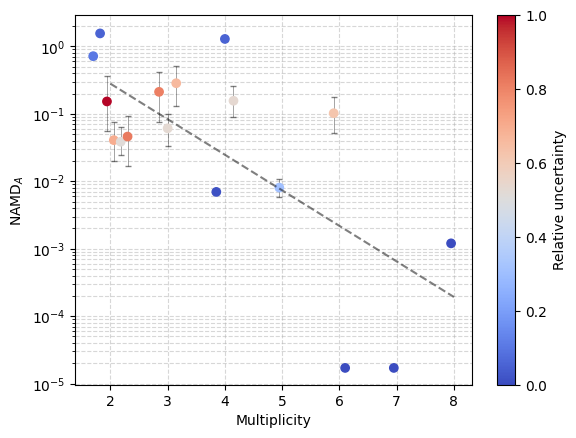

2024-12-27 17:05:12.307 | INFO     | __main__:<module>:12 - Plot done


In [669]:
logger.info("Plotting the NAMD vs. multiplicity")
pop_plot(
    df=df.groupby("hostname").apply(
        lambda g: g.select_dtypes(exclude=["object"]).mean(),
    ),
    kind="abs",
    # title="Core planets",
    which="namd",
    yscale="log",
    xoffs=True,
)
logger.info("Plot done")

In [670]:
# Npt = 10000000
# threshold = 1000

In [671]:
# plot_host_namd(
#     df=df,
#     hostname="TRAPPIST-1",
#     kind="abs",
#     Npt=Npt,
#     threshold=threshold,
# )

In [672]:
# plot_host_namd(
#     df=df,
#     hostname="Kepler-462",
#     kind="abs",
#     Npt=Npt,
#     threshold=threshold,
# )

TODO: 

1. check systems where the sy_pnum is different from the number of planets in the system reported in the exoplanet archive. e.g. XO-2 N
2. check compatibility with TepCat

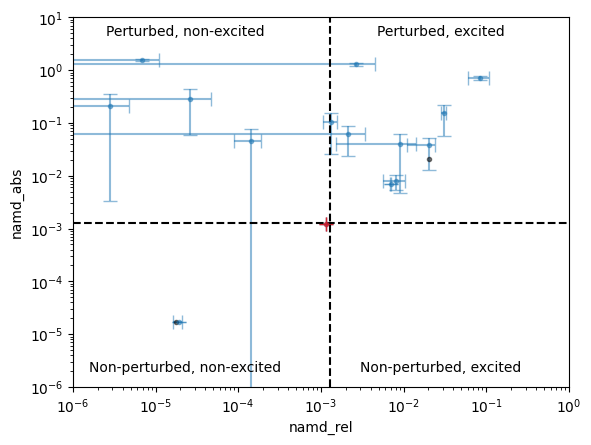

In [717]:
df_plot = df.groupby("hostname")[
    [
        "namd_rel",
        "namd_abs",
        "namd_rel_q16",
        "namd_rel_q50",
        "namd_rel_q84",
        "namd_abs_q16",
        "namd_abs_q50",
        "namd_abs_q84",
    ]
].apply(lambda g: g.select_dtypes(exclude=["object"]).mean())


import matplotlib.pyplot as plt

fig = plt.figure()

plt.yscale("log")
plt.xscale("log")
plt.xlabel("namd_rel")
plt.ylabel("namd_abs")

plt.errorbar(
    x=df_plot["namd_rel_q50"],
    y=df_plot["namd_abs_q50"],
    xerr=(
        df_plot["namd_rel_q84"] - df_plot["namd_rel_q50"],
        df_plot["namd_rel_q50"] - df_plot["namd_rel_q16"],
    ),
    yerr=(
        df_plot["namd_abs_q84"] - df_plot["namd_abs_q50"],
        df_plot["namd_abs_q50"] - df_plot["namd_abs_q16"],
    ),
    fmt="o",
    markersize=3,
    capsize=5,
    alpha=0.5,
)

SS = df_plot[df_plot.index == "SS"]

plt.errorbar(
    x=SS["namd_rel_q50"],
    y=SS["namd_abs_q50"],
    xerr=(
        SS["namd_rel_q84"] - SS["namd_rel_q50"],
        SS["namd_rel_q50"] - SS["namd_rel_q16"],
    ),
    yerr=(
        SS["namd_abs_q84"] - SS["namd_abs_q50"],
        SS["namd_abs_q50"] - SS["namd_abs_q16"],
    ),
    fmt="o",
    markersize=3,
    capsize=5,
    alpha=0.5,
    color="r",
)

missing_mc = df_plot[
    np.logical_or(df_plot["namd_abs_q50"].isna(), df_plot["namd_rel_q50"].isna())
]

plt.plot(
    missing_mc["namd_rel"],
    missing_mc["namd_abs"],
    "o",
    color="k",
    alpha=0.5,
    markersize=3,
)

ymin = 1e-6
ymax = 10
xmin = 1e-6
xmax = 1

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.vlines(1.3e-3, *plt.ylim(), colors=["k"], linestyles=["--"])
plt.hlines(1.3e-3, *plt.xlim(), colors=["k"], linestyles=["--"])

fig.text(0.3, 0.85, "Perturbed, non-excited", ha="center", va="center")
fig.text(0.7, 0.85, "Perturbed, excited", ha="center", va="center")

fig.text(0.3, 0.15, "Non-perturbed, non-excited", ha="center", va="center")
fig.text(0.7, 0.15, "Non-perturbed, excited", ha="center", va="center")

plt.show()

In [718]:
# df[["pl_name", "namd_rel", "namd_abs"]].values

In [720]:
# df[df["hostname"].isin(["TRAPPIST-1", "TOI-942"])].to_csv("deleteme.csv")

In [721]:
# df["hostname"].unique().size

In [722]:
# df_exo = pd.read_csv(
#     os.path.join('../exonamd', "data", "exo.csv"),
# )

# systems = ["TRAPPIST-1", "HD 110067", "55 Cnc", "KOI-351", "GJ 876"]
# df_exo = df_exo[df_exo["hostname"].isin(systems)]

# df_exo = df_exo[df_exo["default_flag"] == 1]

# # df_exo["pl_trueobliq"] = df_exo["pl_trueobliq"].fillna(np.random.uniform(0, 15))
# # df_exo["pl_orbeccen"] = df_exo["pl_orbeccen"].fillna(np.random.uniform(0, 0.15))
# # df_exo["pl_orbeccen"] = 0.0
# df_exo["pl_trueobliq"] = df_exo["pl_trueobliq"].fillna(np.random.uniform(0.005, 0.01))
# df_exo["pl_orbeccen"] = df_exo["pl_orbeccen"].fillna(np.random.uniform(0.005, 0.01))

# df_exo.to_csv(os.path.join('../exonamd', "data", "df_exo_famous.csv"), index=False)

# df_db = pd.read_csv(
#     os.path.join('../exonamd', "data", "custom_db_20241227.csv"),
# )

# df_db.loc[df_db["hostname"] == "TOI-942", "pl_orbeccen"] = 0.2
# df_db.loc[df_db["hostname"] == "TOI-942", "pl_orbeccenerr1"] = 0.1
# df_db.loc[df_db["hostname"] == "TOI-942", "pl_orbeccenerr2"] = -0.001

# df_new = pd.concat([df_db, df_exo])
# df_new.to_csv(os.path.join('../exonamd', "data", "custom_db_20241227_plus_famous.csv"), index=False)

# df_exo[["default_flag", "pl_name", "pl_bmasse", "pl_trueobliq", "pl_orbeccen"]].values

In [678]:
# df.loc[df["hostname"] == "TOI-942", "pl_orbeccenerr2"] = -0.01

In [719]:
# df.loc[df["hostname"] == "TOI-942", ["pl_bmasse", "pl_bmasseerr1", "pl_bmasseerr2"]]